# Cold Face Test – Saliva Plots

In [1]:
import json
import re
from pathlib import Path

import pandas as pd
import numpy as np
import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns

from fau_colors import cmaps, register_fausans_font
import biopsykit as bp
from biopsykit.utils.dataframe_handling import multi_xs
from biopsykit.protocols import MIST

from cft_analysis.datasets import CftDatasetProcessed

%load_ext autoreload
%autoreload 2
%matplotlib widget

In [33]:
plt.close("all")

register_fausans_font()
palette = sns.color_palette(cmaps.faculties)
sns.set_theme(context="notebook", style="ticks", palette=palette)

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["mathtext.default"] = "regular"

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "FAUSans Office"

palette

[(0.0, 0.1843137254901961, 0.4235294117647059),
 (0.4666666666666667, 0.6235294117647059, 0.7098039215686275),
 (1.0, 0.7215686274509804, 0.10980392156862745),
 (0.0, 0.6392156862745098, 0.8784313725490196),
 (0.2627450980392157, 0.6901960784313725, 0.16470588235294117),
 (0.7843137254901961, 0.06274509803921569, 0.1803921568627451)]

## Data Import

In [3]:
# get path to analysis results
data_path = Path("../../2022_scientific_reports/data")
base_path = Path("..")

In [4]:
results_path = base_path.joinpath("results")
plot_path = results_path.joinpath("plots")
bp.utils.file_handling.mkdirs([results_path, plot_path])

In [5]:
dataset = CftDatasetProcessed(data_path, exclude_subjects=True)
dataset

,condition,subject,phase,subphase
0,CFT,Vp01,MIST1,AT
1,CFT,Vp01,MIST1,AT
2,CFT,Vp01,MIST1,AT
3,CFT,Vp01,MIST1,AT
4,CFT,Vp01,MIST1,AT
...,...,...,...,...
4443,Control,Vp33,Post,Total
4444,Control,Vp33,Pre,Total
4445,Control,Vp33,Pre,Total
4446,Control,Vp33,Pre,Total


In [6]:
hue_order = ["Control", "CFT"]

In [7]:
mist = MIST.from_file(data_path.joinpath("mist_cft.json"))
mist

CFT
        Structure: {'Pre': None, 'MIST': {'MIST1': {'BL': 60, 'RP_CFI': 120, 'AT': 240, 'FB': 0}, 'MIST2': {'BL': 60, 'RP_CFI': 120, 'AT': 240, 'FB': 0}, 'MIST3': {'BL': 60, 'RP_CFI': 120, 'AT': 240, 'FB': 0}}, 'Post': None}

## Plots

### Cortisol Response

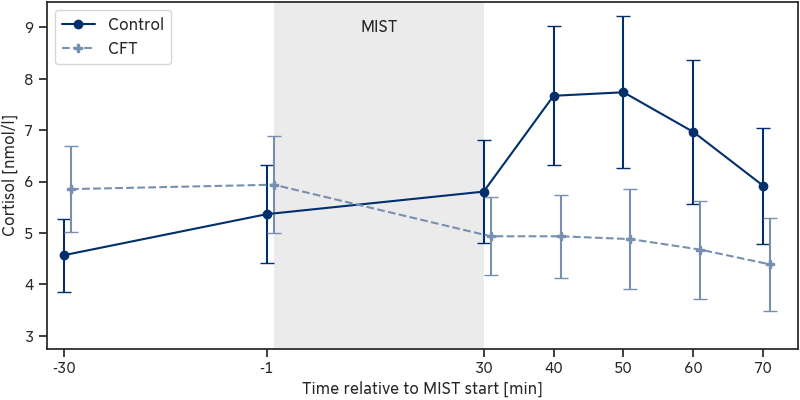

In [60]:
fig, ax = plt.subplots(figsize=(8, 4))

mist.add_saliva_data(dataset.cortisol, "cortisol", sample_times=dataset.sample_times)

mist.saliva_plot(
    "cortisol",
    legend_loc="upper left",
    legend_fontsize="medium",
    hue_order=hue_order,
    linestyle=["-", "--"],
    marker=["o", "P"],
    ax=ax,
)
ax.set_xlim([-32.5, 75])
ax.set_ylim([2.75, 9.5])

fig.tight_layout(pad=0.1)

fig.savefig(plot_path.joinpath("img_cortisol_response.pdf"), transparent=True)

### Cortisol Features

#### Prepare Data

In [10]:
features = ["auc_g", "auc_i", "auc_i_post", "max_inc", "slopeS1S4"]

cort_analysis = multi_xs(dataset.cortisol_features, features, level="saliva_feature")
cort_analysis.head()

cortisol
condition subject saliva_feature            
CFT       Vp01    auc_g           395.430700
                  auc_i          -103.926500
                  auc_i_post      -34.190750
                  max_inc          -1.256500
                  slopeS1S4        -0.039711

#### Statistics

In [11]:
steps = [
    ("prep", "normality"),
    ("test", "pairwise_tests"),
]
params = {"dv": "cortisol", "between": "condition", "groupby": "saliva_feature", "test__parametric": False}

stats = bp.stats.StatsPipeline(steps, params)
stats.apply(cort_analysis)
stats.display_results(prep=False)

<font size="3"><b> Overview </b></font>

,dv,between,groupby,test__parametric
parameter,cortisol,condition,saliva_feature,False


,prep,test
parameter,normality,pairwise_tests


<font size="3"><b> Statistical Tests </b></font>

**Pairwise Tests**

,,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,hedges
saliva_feature,,,,,,,,,,
auc_g,0,condition,CFT,Control,False,False,64.0,two-sided,0.4628,-0.380443
auc_i,0,condition,CFT,Control,False,False,44.0,two-sided,0.0684,-0.786745
auc_i_post,0,condition,CFT,Control,False,False,40.0,two-sided,0.0414,-0.821647
max_inc,0,condition,CFT,Control,False,False,40.0,two-sided,0.0414,-0.863093
slopeS1S4,0,condition,CFT,Control,False,False,36.0,two-sided,0.0240,-0.886565


#### Boxplots

## Combined Plot

/Users/richer/Documents/PhD/Code_Repositories/HealthPsychology/ColdFaceTest/cft_analysis/.venv/lib/python3.10/site-packages/biopsykit/stats/stats.py:552: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, (idx, sig_pair) in enumerate(box_pairs.iteritems()):


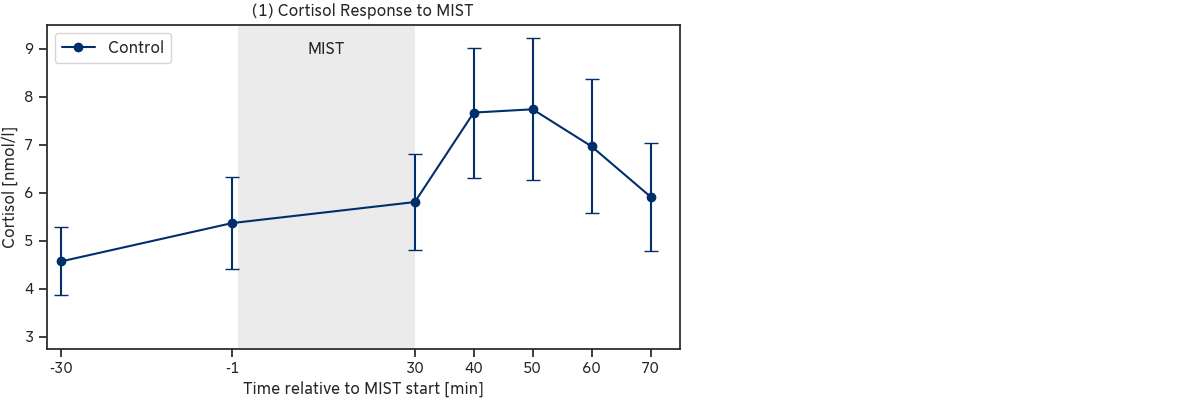

In [61]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 4), gridspec_kw={"width_ratios": [4, 1, 1]})

mist.add_saliva_data(dataset.cortisol.xs("Control", drop_level=False), "cortisol", sample_times=dataset.sample_times)

mist.saliva_plot(
    "cortisol",
    legend_loc="upper left",
    legend_fontsize="medium",
    hue_order=["Control"],
    linestyle=["-"],
    marker=["o"],
    ax=axs[0],
)
axs[0].set_xlim([-32.5, 75])
axs[0].set_ylim([2.75, 9.5])

features = {"auc_i": ["auc_i"], "max_inc": ["max_inc"]}
xticklabels = {"max_inc": ["Control", "CFT"]}

box_pairs, pvalues = stats.sig_brackets(
    "test", stats_effect_type="between", plot_type="single", x="saliva_feature", features=features, subplots=True
)

bp.protocols.plotting.saliva_multi_feature_boxplot(
    data=dataset.cortisol_features,
    saliva_type="cortisol",
    x="condition",
    features=features,
    xticklabels=xticklabels,
    order=hue_order,
    legend_loc="upper center",
    legend_orientation="vertical",
    stats_kwargs={"box_pairs": box_pairs, "pvalues": pvalues, "verbose": 0},
    palette=cmaps.faculties_light,
    axs=axs[1:],
)

for ax, text, title in zip(axs, list("123"), ["Cortisol Response to MIST", r"$\Delta c_{max}$", r"$AUC_{G}$"]):
    ax.set_title(f"({text}) {title}")

#fig.legends[0].remove()
fig.tight_layout(pad=0.1, w_pad=1.0)

for ax in axs[1:]:
    ax.set_visible(False)

fig.savefig(plot_path.joinpath("img_cortisol_combined_control.pdf"), transparent=True)

/Users/richer/Documents/PhD/Code_Repositories/HealthPsychology/ColdFaceTest/cft_analysis/.venv/lib/python3.10/site-packages/biopsykit/stats/stats.py:552: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, (idx, sig_pair) in enumerate(box_pairs.iteritems()):


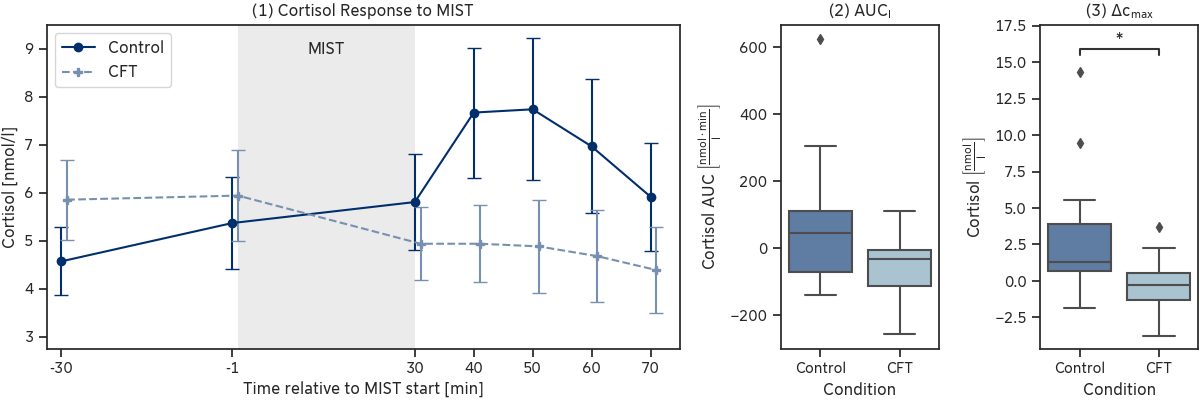

In [62]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 4), gridspec_kw={"width_ratios": [4, 1, 1]})

mist.add_saliva_data(dataset.cortisol, "cortisol", sample_times=dataset.sample_times)

mist.saliva_plot(
    "cortisol",
    legend_loc="upper left",
    legend_fontsize="medium",
    hue_order=hue_order,
    linestyle=["-", "--"],
    marker=["o", "P"],
    ax=axs[0],
)
axs[0].set_xlim([-32.5, 75])
axs[0].set_ylim([2.75, 9.5])

features = {"auc_i": ["auc_i"], "max_inc": ["max_inc"]}
xticklabels = {"max_inc": ["Control", "CFT"]}

box_pairs, pvalues = stats.sig_brackets(
    "test", stats_effect_type="between", plot_type="single", x="saliva_feature", features=features, subplots=True
)

bp.protocols.plotting.saliva_multi_feature_boxplot(
    data=dataset.cortisol_features,
    saliva_type="cortisol",
    x="condition",
    features=features,
    xticklabels=xticklabels,
    order=hue_order,
    legend_loc="upper center",
    legend_orientation="vertical",
    stats_kwargs={"box_pairs": box_pairs, "pvalues": pvalues, "verbose": 0},
    palette=cmaps.faculties_light,
    axs=axs[1:],
)

for ax, text, title in zip(axs, list("123"), ["Cortisol Response to MIST", r"$AUC_{I}$", r"$\Delta c_{max}$"]):
    ax.set_title(f"({text}) {title}")

for ax in axs[1:]:
    ax.set_xlabel("Condition")

#fig.legends[0].remove()
fig.tight_layout(pad=0.1, w_pad=1.0)

fig.savefig(plot_path.joinpath("img_cortisol_combined.pdf"), transparent=True)